In [1]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import pickle as pkl
from PIL import Image

In [2]:
class FashionRecommendationSystem:
    def __init__(self, csv_path=None, image_path=None):
        # Chemin par défaut si non spécifié
        if csv_path is None:
            csv_path = '../dataset/styles.csv'
        if image_path is None:
            image_path = '../dataset/images'

        # Lire le CSV et définir le chemin des images
        self.df = pd.read_csv(csv_path, on_bad_lines='skip')
        self.image_path = image_path

        # Nettoyage des données
        self.clean_data()

        # Préparer les features
        self.prepare_features()

    def clean_data(self):
        # Remplacer les NaN par des chaînes vides
        columns_to_clean = ['gender', 'season', 'baseColour', 'articleType']
        for col in columns_to_clean:
            self.df[col] = self.df[col].fillna('')

    def prepare_features(self):
        # Combinaison des features textuelles avec gestion des NaN
        self.df['full_features'] = (
            self.df['gender'] + ' ' +
            self.df['season'] + ' ' +
            self.df['baseColour'] + ' ' +
            self.df['articleType']
        )

        # Filtrer les lignes avec des features non vides
        self.df = self.df[self.df['full_features'].str.strip() != '']

        # Vectorisation TF-IDF avec gestion des erreurs
        self.tfidf = TfidfVectorizer(stop_words='english')

        # Vérifier que nous avons des documents non vides
        non_empty_features = self.df['full_features'].dropna()

        if len(non_empty_features) == 0:
            raise ValueError("Aucun document valide pour la vectorisation")

        self.feature_matrix = self.tfidf.fit_transform(non_empty_features)

    def recommend(self, preferences, top_n=5):
        # Construire la requête de préférences
        query = ' '.join([
            preferences.get('gender', ''),
            preferences.get('season', ''),
            preferences.get('baseColour', ''),
            preferences.get('articleType', '')
        ]).strip()

        # Vectoriser la requête
        query_vector = self.tfidf.transform([query])

        # Calculer la similarité cosinus
        similarity_scores = cosine_similarity(query_vector, self.feature_matrix).flatten()

        # Filtrage initial basé sur les préférences
        mask = np.ones(len(self.df), dtype=bool)
        for key, value in preferences.items():
            if value:
                mask &= (self.df[key] == value)

        # Obtenir les indices triés par similarité
        similar_indices = similarity_scores.argsort()[::-1]

        # Filtrer et limiter les recommandations
        filtered_indices = [idx for idx in similar_indices if mask[idx]][:top_n]

        # Préparer les recommandations avec leurs scores de similarité
        recommendations = self.df.iloc[filtered_indices].copy()
        recommendations['similarity_score'] = similarity_scores[filtered_indices]

        return recommendations[['id', 'productDisplayName', 'gender', 'season', 'baseColour', 'articleType', 'similarity_score']]

    def display_images(self, recommendations):
    # Créer une figure pour afficher les images
        plt.figure(figsize=(15, 10))

    # Utiliser un compteur pour les indices de subplot
        for idx, (_, row) in enumerate(recommendations.iterrows()):
            image_file = os.path.join(self.image_path, f"{row['id']}.jpg")
            try:
            # Charger et afficher l'image
                img = Image.open(image_file)
                plt.subplot(1, len(recommendations), idx + 1)  # Utiliser idx + 1 comme index
                plt.imshow(img)
                plt.axis('off')
                plt.title("Recommandation", fontsize=10)
            except FileNotFoundError:
                print(f"Image non trouvée pour ID : {row['id']}")

    plt.show()

Recommandations basées sur vos préférences :
   id                        productDisplayName gender season baseColour articleType  similarity_score
 2276 Nike Mens Challenger Graphic Blue T-shirt    Men   Fall       Blue     Tshirts          0.821617
13220  Palm Tree Kids Boys Printed Blue Tshirts    Men   Fall       Blue     Tshirts          0.821617
 1796       Domyos Men Performance Blue T-shirt    Men   Fall       Blue     Tshirts          0.821617
 7789             Proline Men Blue Polo T-shirt    Men   Fall       Blue     Tshirts          0.821617
23873                   ADIDAS Men Blue T-shirt    Men   Fall       Blue     Tshirts          0.821617


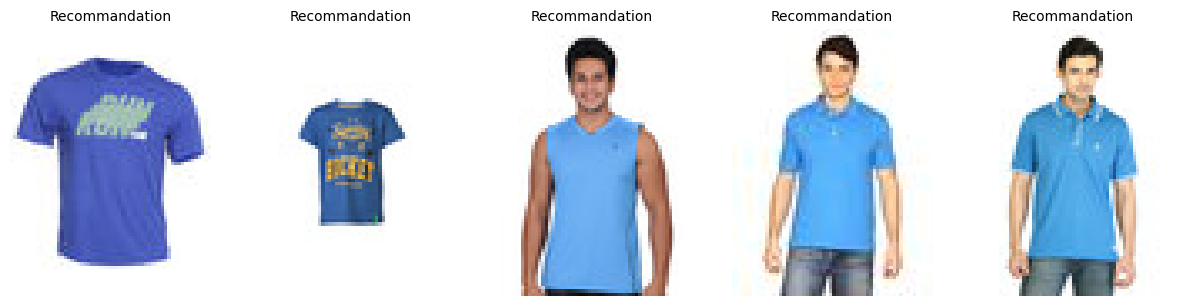

In [3]:
# Initialiser le système de recommandation
csv_path = '../dataset/styles.csv'
image_path = '../dataset/images'
recommender = FashionRecommendationSystem(csv_path, image_path)

# Définir les préférences
preferences = {
    'gender': 'Men',
    'season': 'Fall',
    'baseColour': 'Blue',
    # 'articleType': 'Jeans'
}

# Obtenir les recommandations
recommendations = recommender.recommend(preferences)

# Afficher les recommandations
print("Recommandations basées sur vos préférences :")
print(recommendations.to_string(index=False))

# Afficher les images correspondantes
recommender.display_images(recommendations)
